<a href="https://colab.research.google.com/github/jhchang/Forecasting-Solar-Irradiance/blob/main/03_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro



# 📈 Modeling: Forecasting Global Horizontal Irradiance (GHI)

This notebook begins the modeling phase of our project, where we apply machine learning techniques to forecast Global Horizontal Irradiance (GHI) at the Al Shuaibah 2 Solar Farm site in Saudi Arabia.

In the previous notebook, we completed extensive exploratory data analysis and feature engineering. The dataset now contains a rich set of features, including raw satellite data, time-based encodings, lag and rolling statistics, and decomposed seasonal trends — all designed to improve predictive accuracy.

### 🔍 Objectives of This Notebook:
- Prepare the data for modeling (train-test split and normalization)
- Train baseline regression models (e.g., Linear Regression, Random Forest)
- Evaluate model performance using metrics such as RMSE and MAE
- Establish a baseline for comparison with more advanced forecasting methods (e.g., LSTM)

This phase marks a transition from data understanding to model-driven insight, forming the foundation for advanced forecasting techniques that will follow.


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Replace with your file path
file_path = "/content/drive/MyDrive/datasets/augmented_weather_data.csv"

df = pd.read_csv(file_path, parse_dates=True, index_col=0)

In [ ]:
display(df.index)  # Should be DatetimeIndex
display(df.iloc[5:10]) # Check your data looks correct

DatetimeIndex(['2021-01-02 00:00:00', '2021-01-02 01:00:00',
               '2021-01-02 02:00:00', '2021-01-02 03:00:00',
               '2021-01-02 04:00:00', '2021-01-02 05:00:00',
               '2021-01-02 06:00:00', '2021-01-02 07:00:00',
               '2021-01-02 08:00:00', '2021-01-02 09:00:00',
               ...
               '2023-12-31 14:00:00', '2023-12-31 15:00:00',
               '2023-12-31 16:00:00', '2023-12-31 17:00:00',
               '2023-12-31 18:00:00', '2023-12-31 19:00:00',
               '2023-12-31 20:00:00', '2023-12-31 21:00:00',
               '2023-12-31 22:00:00', '2023-12-31 23:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=26256, freq=None)

,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,ALLSKY_SFC_SW_DNI,ALLSKY_SFC_SW_DIFF,ALLSKY_KT,ALLSKY_SRF_ALB,SZA,ALLSKY_SFC_PAR_TOT,CLRSKY_SFC_PAR_TOT,ALLSKY_SFC_UV_INDEX,...,month,weekday,is_weekend,hour_sin,hour_cos,GHI_lag_1h,GHI_lag_24h,GHI_roll_mean_3h,T2M_roll_std_6h,is_daylight
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-02 05:00:00,0.00,0.00,0.00,0.00,0.00,0.00,90.00,0.00,0.00,0.00,...,1,5,1,0.965926,2.588190e-01,0.00,0.00,0.000000,0.310832,0
2021-01-02 06:00:00,0.00,0.00,0.00,0.00,0.00,0.00,90.00,0.00,0.00,0.00,...,1,5,1,1.000000,6.123234e-17,0.00,0.00,0.000000,0.262202,0
2021-01-02 07:00:00,42.70,43.65,41.01,37.63,0.32,0.24,84.63,19.30,19.52,0.03,...,1,5,1,0.965926,-2.588190e-01,0.00,39.72,14.233333,0.283455,1
2021-01-02 08:00:00,222.38,224.75,324.27,122.02,0.53,0.21,72.69,101.08,101.80,0.52,...,1,5,1,0.866025,-5.000000e-01,42.70,203.00,88.360000,0.879532,1
2021-01-02 09:00:00,412.70,416.65,523.88,157.01,0.62,0.12,61.82,188.95,190.38,1.83,...,1,5,1,0.707107,-7.071068e-01,222.38,367.80,225.926667,1.518117,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26256 entries, 2021-01-02 00:00:00 to 2023-12-31 23:00:00
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ALLSKY_SFC_SW_DWN    26256 non-null  float64
 1   CLRSKY_SFC_SW_DWN    26256 non-null  float64
 2   ALLSKY_SFC_SW_DNI    26256 non-null  float64
 3   ALLSKY_SFC_SW_DIFF   26256 non-null  float64
 4   ALLSKY_KT            26256 non-null  float64
 5   ALLSKY_SRF_ALB       26256 non-null  float64
 6   SZA                  26256 non-null  float64
 7   ALLSKY_SFC_PAR_TOT   26256 non-null  float64
 8   CLRSKY_SFC_PAR_TOT   26256 non-null  float64
 9   ALLSKY_SFC_UV_INDEX  26256 non-null  float64
 10  QV2M                 26256 non-null  float64
 11  T2M                  26256 non-null  float64
 12  T2MDEW               26256 non-null  float64
 13  T2MWET               26256 non-null  float64
 14  PRECTOTCORR          26256 non-null  float64
 15  P

In [ ]:
df.describe()

,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,ALLSKY_SFC_SW_DNI,ALLSKY_SFC_SW_DIFF,ALLSKY_KT,ALLSKY_SRF_ALB,SZA,ALLSKY_SFC_PAR_TOT,CLRSKY_SFC_PAR_TOT,ALLSKY_SFC_UV_INDEX,...,month,weekday,is_weekend,hour_sin,hour_cos,GHI_lag_1h,GHI_lag_24h,GHI_roll_mean_3h,T2M_roll_std_6h,is_daylight
count,26256.000000,26256.000000,26256.000000,26256.000000,26256.000000,26256.000000,26256.000000,26256.000000,26256.000000,26256.000000,...,26256.000000,26256.000000,26256.000000,2.625600e+04,2.625600e+04,26256.000000,26256.000000,26256.000000,26256.000000,26256.000000
mean,256.042522,268.076074,227.522008,91.936303,0.301302,0.094358,70.814096,116.724540,121.382023,2.143615,...,6.531079,3.004570,0.286106,-1.853754e-17,-5.561263e-17,256.042522,255.998485,256.042522,1.245064,0.512797
std,334.727750,345.853077,291.421591,113.480390,0.314411,0.097804,24.716001,152.436219,156.545669,3.418436,...,3.445440,2.001175,0.451948,7.071202e-01,7.071202e-01,334.727750,334.695729,322.642400,0.831258,0.499846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.060000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,-1.000000e+00,-1.000000e+00,0.000000,0.000000,0.000000,0.027869,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,52.440000,0.000000,0.000000,0.000000,...,4.000000,1.000000,0.000000,-7.071068e-01,-7.071068e-01,0.000000,0.000000,0.000000,0.564338,0.000000
50%,13.260000,14.000000,1.600000,14.835000,0.250000,0.090000,87.870000,5.800000,6.120000,0.030000,...,7.000000,3.000000,0.000000,6.123234e-17,-6.123234e-17,13.260000,13.260000,55.341667,1.033655,1.000000
75%,532.532500,578.820000,487.527500,179.692500,0.640000,0.180000,90.000000,245.005000,264.405000,3.580000,...,10.000000,5.000000,1.000000,7.071068e-01,7.071068e-01,532.532500,532.280000,521.709167,1.789477,1.000000
max,1088.120000,1090.430000,1061.740000,562.010000,0.820000,0.360000,90.000000,478.720000,475.260000,16.050000,...,12.000000,6.000000,1.000000,1.000000e+00,1.000000e+00,1088.120000,1088.120000,1062.233333,5.100172,1.000000


# Preparing data for train-test split for forecasting

## ⚠⚠⚠ Rolling window columns can cause data leakage

Make sure your augmented data doesn't use values from future records that are included in the test or validation set. If your window is centered, make sure your window is big enough for my case my biggest window size is 6 so I need to shift my dataset for my target column by at least 6//2 = 3.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

df['TARGET'] = df['ALLSKY_SFC_SW_DWN'].shift(-1)  # predict 1 hour ahead
df = df.dropna()  # Drop the last row with NaN target

# Define features and target
features = df.drop(columns=['TARGET'])  # Remove target
target = df['TARGET']

# Train-test split (time-based)
split_index = int(len(df) * 0.8)
X_train, X_test = features.iloc[:split_index], features.iloc[split_index:]
y_train, y_test = target.iloc[:split_index], target.iloc[split_index:]

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a baseline model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Linear Regression RMSE: {rmse:.2f} W/m²")
print(f"Linear Regression MAE: {mae:.2f} W/m²")


Linear Regression RMSE: 28.47 W/m²
Linear Regression MAE: 19.10 W/m²


In [ ]:
target_std = y_test.std()
relative_rmse = rmse / target_std
print(f"Relative RMSE: {relative_rmse:.2f}")


Relative RMSE: 0.08



### ✅ Intuition: RMSE vs. Standard Deviation (`σ`)

* The **standard deviation** of the target variable (e.g., GHI) tells us how spread out the real data is.
* The **RMSE** tells you how far, on average, the predictions are from the true values.

So, if the model's RMSE is **much smaller** than the standard deviation, we're doing better than a "blind guess."

---

### 📊 Key Metric: **Relative RMSE**

You can define this metric as:

$$
\text{Relative RMSE} = \frac{\text{RMSE}}{\text{std of actual target}} \quad (\text{often written as } \frac{\text{RMSE}}{\sigma})
$$

#### 🟢 Interpretation:

| Relative RMSE (RMSE / σ) | Intuition                                    |
| ------------------------ | -------------------------------------------- |
| < 0.5                    | Very strong predictive power                 |
| 0.5 – 0.8                | Good predictive power                        |
| 0.8 – 1.0                | Moderate, but better than guessing the mean  |
| > 1.0                    | Weak — your model is no better than guessing |

Based on our results our baseline model is performing very well already.
---

In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=200)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)
print(f"XGBoost RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f}")

XGBoost RMSE: 19.62


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,       # Number of trees
    max_depth=10,           # Prevent overfitting
    min_samples_split=5,    # Minimum samples to split a node
    random_state=42,
    n_jobs=-1              # Use all CPU cores
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"Random Forest RMSE: {rmse:.2f} W/m²")
print(f"Random Forest MAE: {mae:.2f} W/m²")

Random Forest RMSE: 19.39 W/m²
Random Forest MAE: 7.77 W/m²


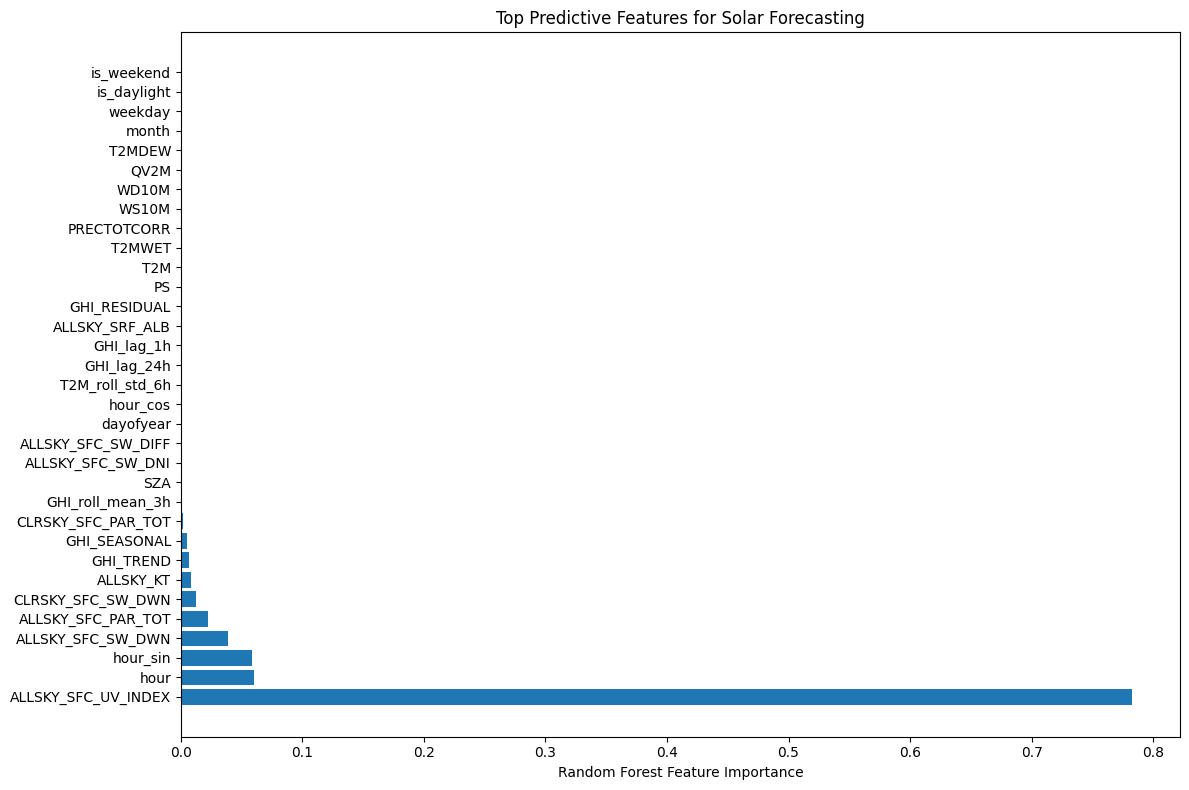

In [ ]:
import matplotlib.pyplot as plt

# Get feature importances
importances = rf.feature_importances_
feature_names = features.columns
sorted_idx = importances.argsort()[::-1]  # Sort descending

# Plot
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("Top Predictive Features for Solar Forecasting")
plt.tight_layout()
plt.show()

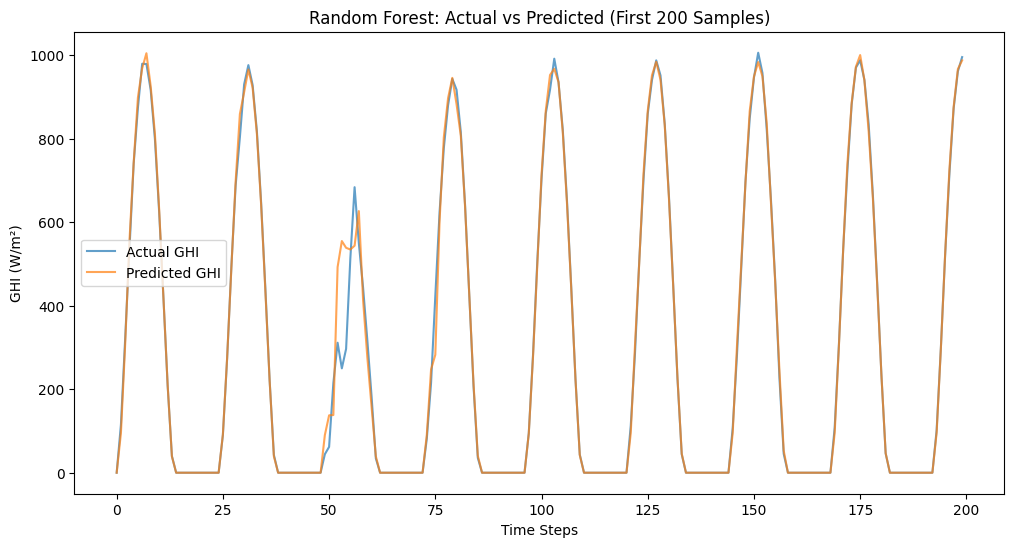

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:200], label='Actual GHI', alpha=0.7)
plt.plot(y_pred[:200], label='Predicted GHI', alpha=0.7)
plt.xlabel("Time Steps")
plt.ylabel("GHI (W/m²)")
plt.title("Random Forest: Actual vs Predicted (First 200 Samples)")
plt.legend()
plt.show()

## Base Model evaluation

- XGBoost and Linear Regression both run almost instantaneously. Random forest does compute 200 trees and takes at least 40 seconds to run.
- The feature UV index seems to be the most important feature for predicting GHI by far.
- There are a lot of 0 GHI values when the sun is not shining on that location and that value is easy to predict. This might skew our evaluation into thinking we predict well.

# How to test our baseline models even further?

So far we only predict 1 hr into the future. Let's try predicting 3 hours into the future.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

df['TARGET'] = df['ALLSKY_SFC_SW_DWN'].shift(-3)  # predict 3 hours ahead
df = df.dropna()  # Drop the last row with NaN target

# Define features and target
features = df.drop(columns=['TARGET'])  # Remove target
target = df['TARGET']

# Train-test split (time-based)
split_index = int(len(df) * 0.8)
X_train, X_test = features.iloc[:split_index], features.iloc[split_index:]
y_train, y_test = target.iloc[:split_index], target.iloc[split_index:]

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a baseline model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Linear Regression RMSE: {rmse:.2f} W/m²")
print(f"Linear Regression MAE: {mae:.2f} W/m²")


Linear Regression RMSE: 67.71 W/m²
Linear Regression MAE: 51.97 W/m²


In [ ]:
target_std = y_test.std()
relative_rmse = rmse / target_std
print(f"Relative RMSE: {relative_rmse:.2f}")


Relative RMSE: 0.20


In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=200)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)
print(f"XGBoost RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f}")

XGBoost RMSE: 30.97


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,       # Number of trees
    max_depth=10,           # Prevent overfitting
    min_samples_split=5,    # Minimum samples to split a node
    random_state=42,
    n_jobs=-1              # Use all CPU cores
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"Random Forest RMSE: {rmse:.2f} W/m²")
print(f"Random Forest MAE: {mae:.2f} W/m²")

Random Forest RMSE: 29.74 W/m²
Random Forest MAE: 12.00 W/m²


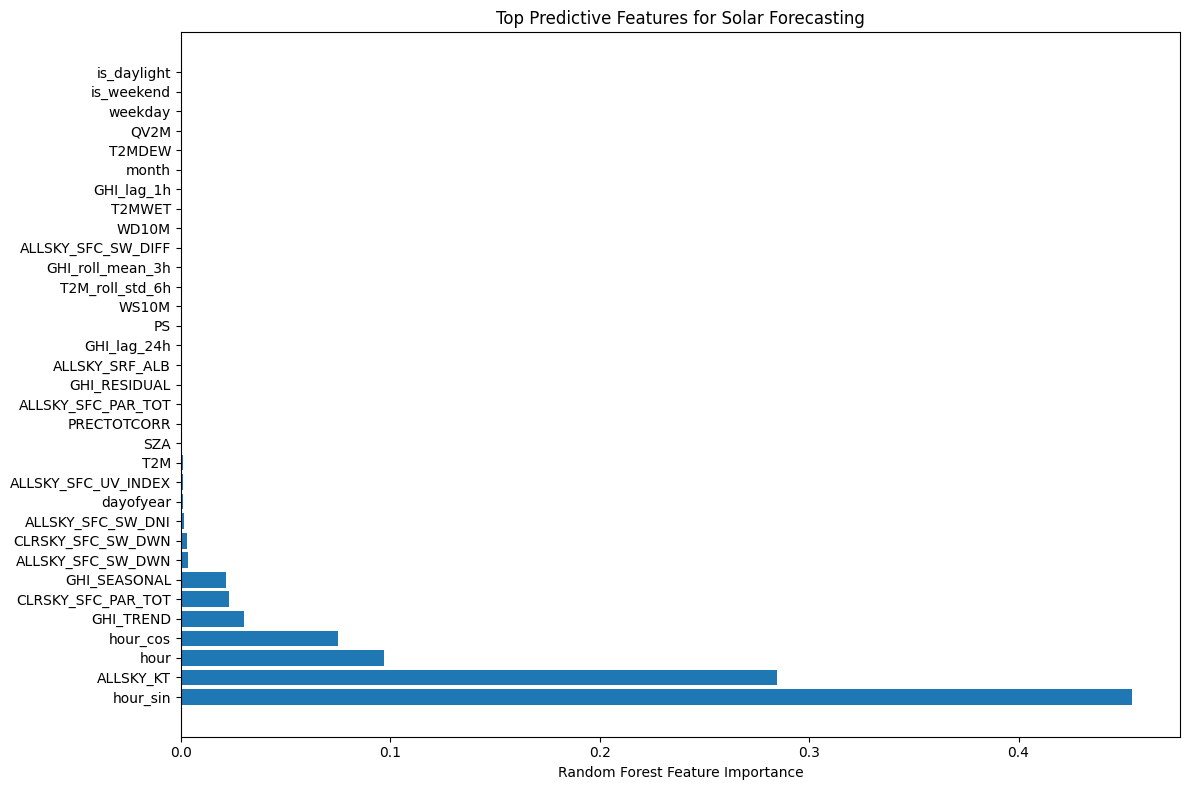

In [ ]:
import matplotlib.pyplot as plt

# Get feature importances
importances = rf.feature_importances_
feature_names = features.columns
sorted_idx = importances.argsort()[::-1]  # Sort descending

# Plot
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("Top Predictive Features for Solar Forecasting")
plt.tight_layout()
plt.show()

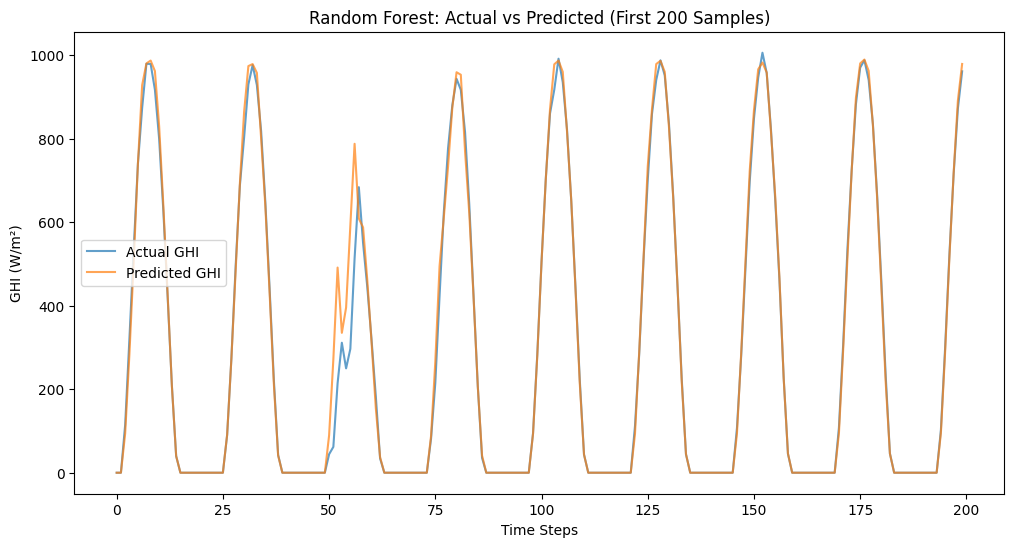

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:200], label='Actual GHI', alpha=0.7)
plt.plot(y_pred[:200], label='Predicted GHI', alpha=0.7)
plt.xlabel("Time Steps")
plt.ylabel("GHI (W/m²)")
plt.title("Random Forest: Actual vs Predicted (First 200 Samples)")
plt.legend()
plt.show()

## 3-hour Forecasting Analysis

- The linear regression model performance significly decreased compared to the other two base models.
- Random Forrest was still the best model.
- The best features for random forest seemed to have changed
    - All Sky Surface UV Index dropped tremendously
    - All Sky Insolation Clearness Index became more important
    - Time related data became the most important.
        - This might be due to the increase in time looking ahead for forecasting demands the model to caputure larger time cyclic trends.

---
# 24 hour horizon

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

df['TARGET'] = df['ALLSKY_SFC_SW_DWN'].shift(-24)  # predict 24 hours ahead
df = df.dropna()  # Drop the last row with NaN target

# Define features and target
features = df.drop(columns=['TARGET'])  # Remove target
target = df['TARGET']

# Train-test split (time-based)
split_index = int(len(df) * 0.8)
X_train, X_test = features.iloc[:split_index], features.iloc[split_index:]
y_train, y_test = target.iloc[:split_index], target.iloc[split_index:]

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a baseline model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Linear Regression RMSE: {rmse:.2f} W/m²")
print(f"Linear Regression MAE: {mae:.2f} W/m²")


Linear Regression RMSE: 36.26 W/m²
Linear Regression MAE: 16.48 W/m²


In [ ]:
target_std = y_test.std()
relative_rmse = rmse / target_std
print(f"Relative RMSE: {relative_rmse:.2f}")


Relative RMSE: 0.11


In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=200)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)
print(f"XGBoost RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f}")

XGBoost RMSE: 40.64


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,       # Number of trees
    max_depth=10,           # Prevent overfitting
    min_samples_split=5,    # Minimum samples to split a node
    random_state=42,
    n_jobs=-1              # Use all CPU cores
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"Random Forest RMSE: {rmse:.2f} W/m²")
print(f"Random Forest MAE: {mae:.2f} W/m²")

Random Forest RMSE: 41.04 W/m²
Random Forest MAE: 16.93 W/m²


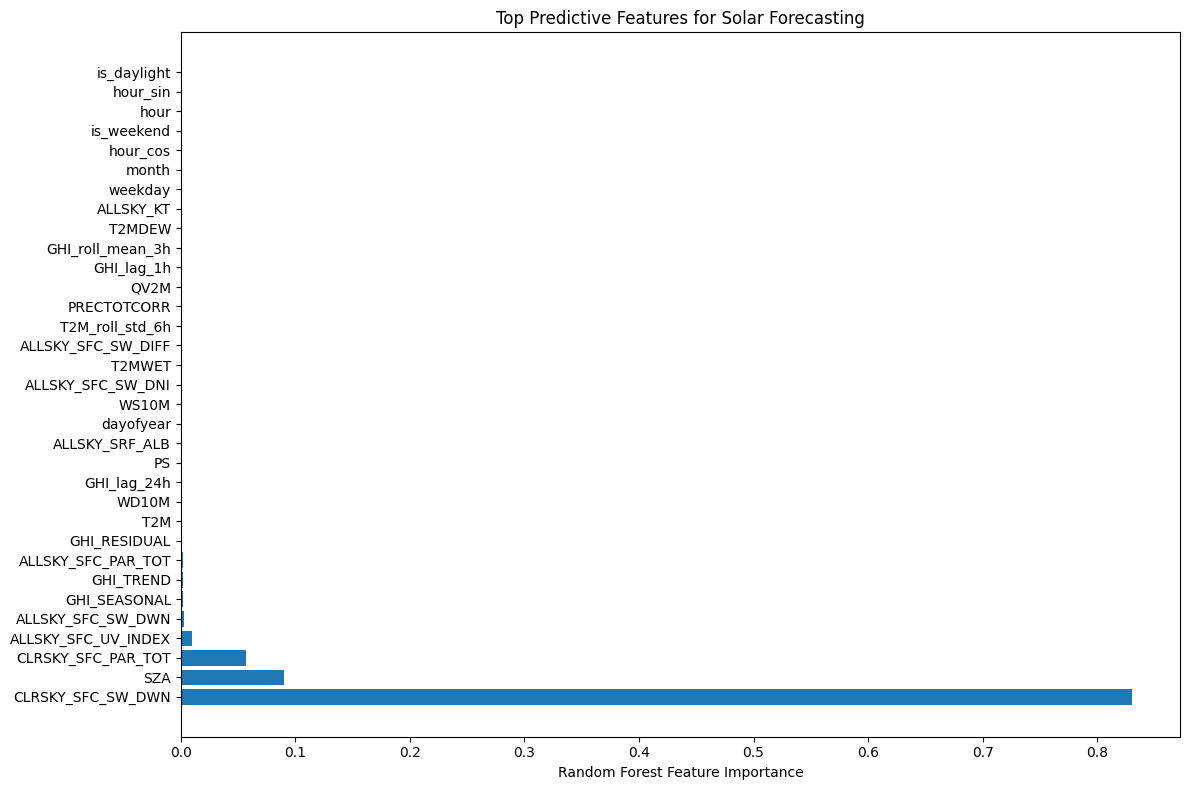

In [ ]:
import matplotlib.pyplot as plt

# Get feature importances
importances = rf.feature_importances_
feature_names = features.columns
sorted_idx = importances.argsort()[::-1]  # Sort descending

# Plot
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("Top Predictive Features for Solar Forecasting")
plt.tight_layout()
plt.show()

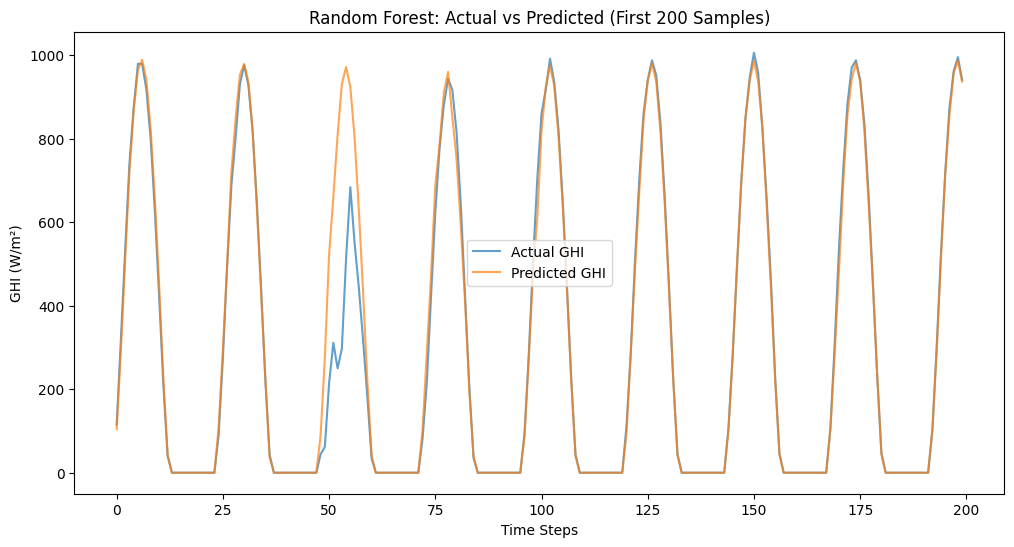

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:200], label='Actual GHI', alpha=0.7)
plt.plot(y_pred[:200], label='Predicted GHI', alpha=0.7)
plt.xlabel("Time Steps")
plt.ylabel("GHI (W/m²)")
plt.title("Random Forest: Actual vs Predicted (First 200 Samples)")
plt.legend()
plt.show()

## Analysis of 24 hour horizon

- Clear Sky Surface Shortwave Downward Irradiance (GHI) is the most influential feature for random forest
- Linear Regression model seemed to be the best performer
    - This might be explained by the full 24 hours maps one whole pattern and linear regression works better on predicting time series data at extact period boundaries.

# 15 day horizon

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

df['TARGET'] = df['ALLSKY_SFC_SW_DWN'].shift(-1*24*15)  # predict 15 days ahead
df = df.dropna()  # Drop the last row with NaN target

# Define features and target
features = df.drop(columns=['TARGET'])  # Remove target
target = df['TARGET']

# Train-test split (time-based)
split_index = int(len(df) * 0.8)
X_train, X_test = features.iloc[:split_index], features.iloc[split_index:]
y_train, y_test = target.iloc[:split_index], target.iloc[split_index:]

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a baseline model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Linear Regression RMSE: {rmse:.2f} W/m²")
print(f"Linear Regression MAE: {mae:.2f} W/m²")


Linear Regression RMSE: 45.95 W/m²
Linear Regression MAE: 24.66 W/m²


In [ ]:
target_std = y_test.std()
relative_rmse = rmse / target_std
print(f"Relative RMSE: {relative_rmse:.2f}")


Relative RMSE: 0.14


In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=200)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)
print(f"XGBoost RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f}")

XGBoost RMSE: 55.27


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,       # Number of trees
    max_depth=10,           # Prevent overfitting
    min_samples_split=5,    # Minimum samples to split a node
    random_state=42,
    n_jobs=-1              # Use all CPU cores
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"Random Forest RMSE: {rmse:.2f} W/m²")
print(f"Random Forest MAE: {mae:.2f} W/m²")

Random Forest RMSE: 45.87 W/m²
Random Forest MAE: 20.84 W/m²


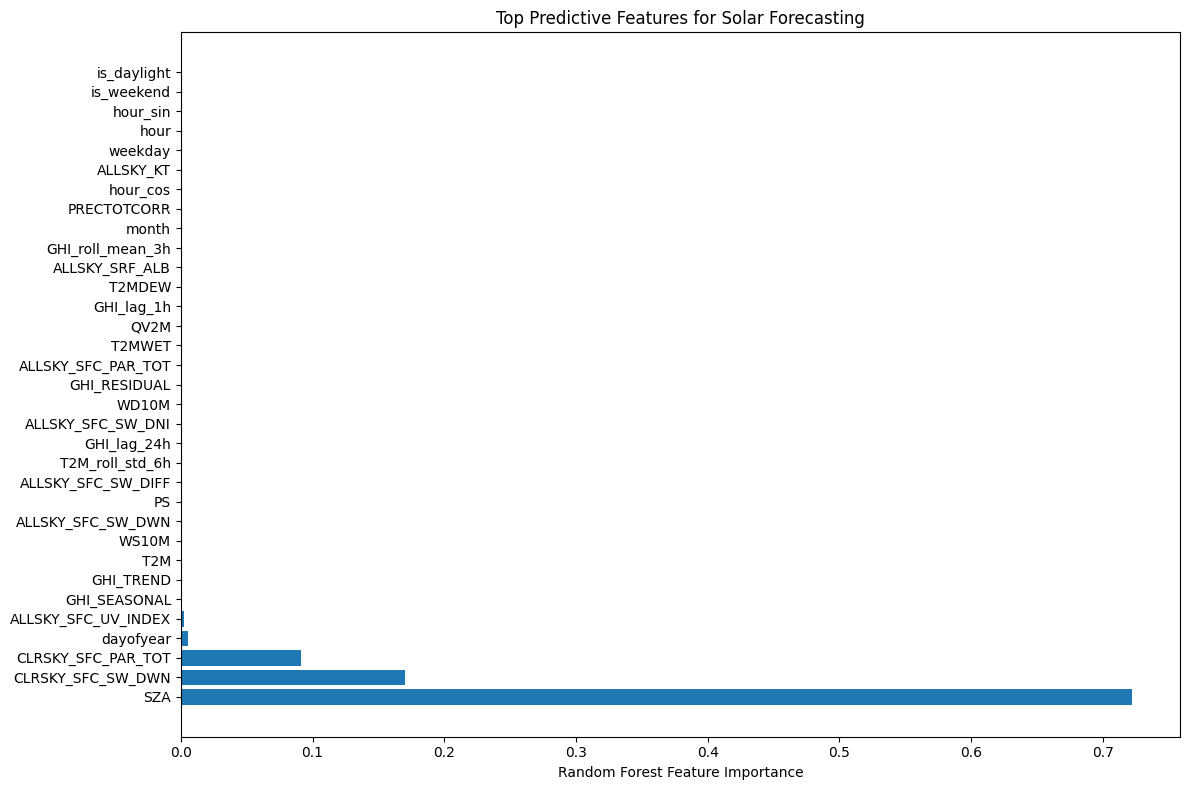

In [ ]:
import matplotlib.pyplot as plt

# Get feature importances
importances = rf.feature_importances_
feature_names = features.columns
sorted_idx = importances.argsort()[::-1]  # Sort descending

# Plot
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("Top Predictive Features for Solar Forecasting")
plt.tight_layout()
plt.show()

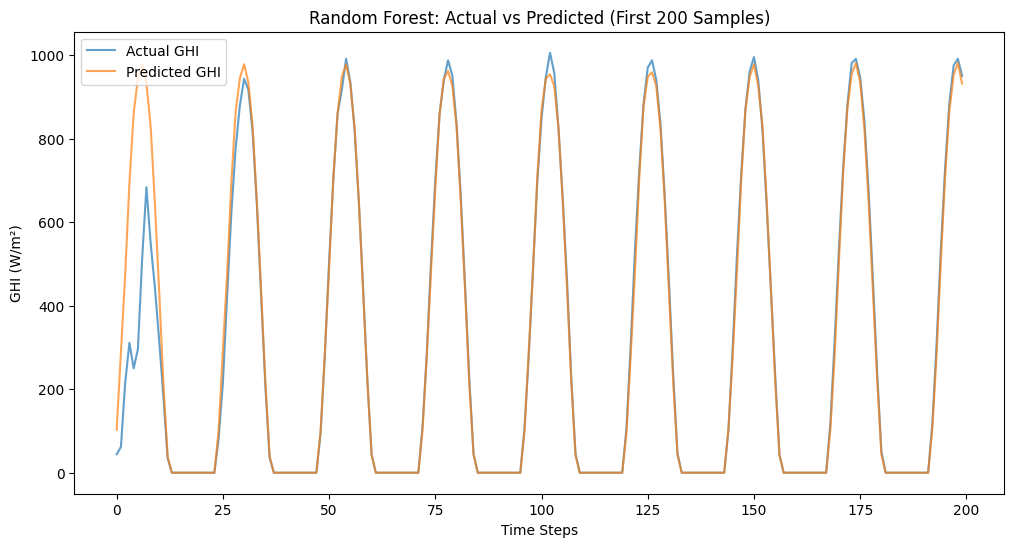

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:200], label='Actual GHI', alpha=0.7)
plt.plot(y_pred[:200], label='Predicted GHI', alpha=0.7)
plt.xlabel("Time Steps")
plt.ylabel("GHI (W/m²)")
plt.title("Random Forest: Actual vs Predicted (First 200 Samples)")
plt.legend()
plt.show()

## Analysis of 15 day horizon

- Random forests became the best performing model again.
- Solar Zenith Angle became the most important feature for random forests

In [ ]:
# get residuals
residuals = y_test - y_pred
abs_error = np.abs(residuals)

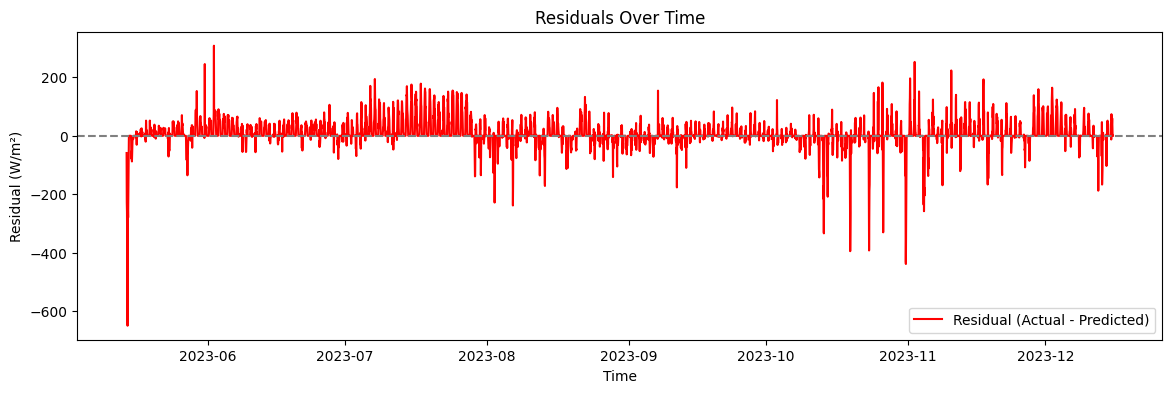

In [ ]:
# This reveals temporal drift or seasonal failure.
# Look for: patterns near season changes, high bias in one part of the year, or sudden shifts.

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 4))
plt.plot(y_test.index, residuals, label='Residual (Actual - Predicted)', color='red')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Residuals Over Time")
plt.xlabel("Time")
plt.ylabel("Residual (W/m²)")
plt.legend()
plt.show()


### Note: residuals are often worse at the beginning of a time series — especially for models that depend on lag features, rolling windows, or state-based learning

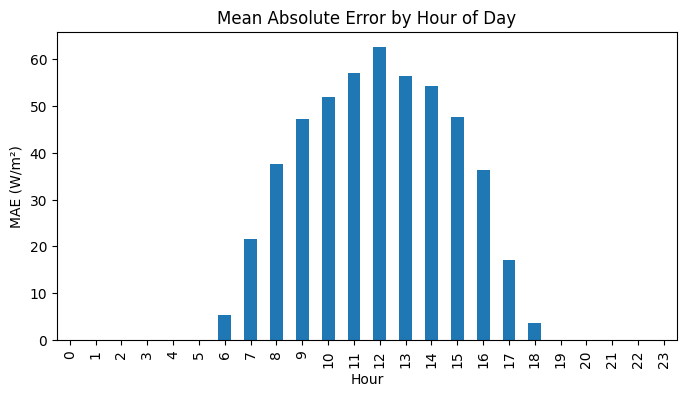

In [ ]:
# Maybe the model does well at noon but fails at sunrise/sunset.
# Look for: higher error at low-light times or sudden transitions (sunrise/sunset).

error_by_hour = pd.DataFrame({'hour': X_test['hour'], 'abs_error': abs_error})
hourly_mae = error_by_hour.groupby('hour')['abs_error'].mean()

plt.figure(figsize=(8, 4))
hourly_mae.plot(kind='bar')
plt.title("Mean Absolute Error by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("MAE (W/m²)")
plt.show()


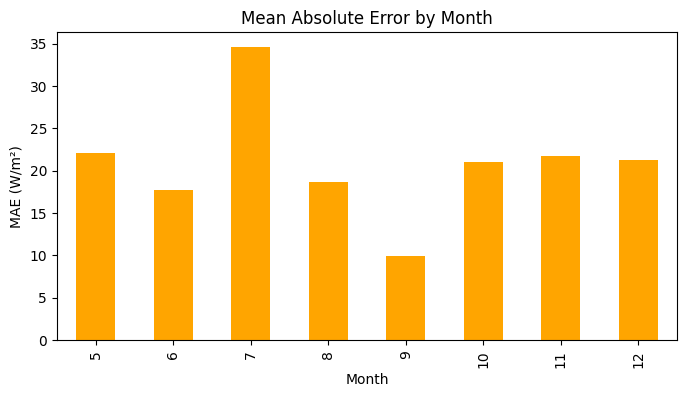

In [ ]:
# This checks if performance varies by time of year.
# Look for: higher error in shoulder seasons (spring/fall), where weather is less stable.

error_by_month = pd.DataFrame({'month': X_test['month'], 'abs_error': abs_error})
monthly_mae = error_by_month.groupby('month')['abs_error'].mean()

plt.figure(figsize=(8, 4))
monthly_mae.plot(kind='bar', color='orange')
plt.title("Mean Absolute Error by Month")
plt.xlabel("Month")
plt.ylabel("MAE (W/m²)")
plt.show()

In [ ]:
# sort the largest errors and inspect their conditions:

top_errors = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Residual': residuals,
    'AbsError': abs_error
}).sort_values(by='AbsError', ascending=False)

# can then cross-reference this with: Time of day, Input feature values (e.g., humidity, temperature), Weather instability

print(top_errors.head(10))


                     Actual   Predicted    Residual    AbsError
timestamp                                                      
2023-05-14 11:00:00  296.60  945.641261 -649.041261  649.041261
2023-05-14 10:00:00  249.93  860.312097 -610.382097  610.382097
2023-05-14 12:00:00  513.38  977.824095 -464.444095  464.444095
2023-10-31 13:00:00  230.48  668.561066 -438.081066  438.081066
2023-10-31 12:00:00  311.08  740.247730 -429.167730  429.167730
2023-10-19 09:00:00  163.82  558.133586 -394.313586  394.313586
2023-10-23 12:00:00  373.40  765.234568 -391.834568  391.834568
2023-05-14 09:00:00  311.33  694.186268 -382.856268  382.856268
2023-10-31 14:00:00  173.30  523.686967 -350.386967  350.386967
2023-10-19 10:00:00  298.52  636.862221 -338.342221  338.342221


# Analysis of test results

---

## 🔍 1. **Residuals Over Time Plot**

**Observation:**

* The first \~20-30 days show **large negative residuals** (i.e., predicted values are much higher than actuals).
* Spikes of large residuals also appear sporadically later (e.g., in October–November), but the **early period stands out** in consistency and severity.

**Probable reasons:**

* **Insufficient lag/rolling features** due to lack of past data.
* **Model overconfidence** at early points (possibly due to missing cyclical/seasonal patterns at the start).
* The model may have been **trained with time leakage or improper shuffling** if not careful — early timestamps often suffer disproportionately if the model can't generalize well.

---

### 📊 2. **MAE by Hour of Day**

**Observation:**

* Errors peak at **solar noon (12–13h)** — likely when GHI values are highest.
* Early/late hours (before 7 AM or after 6 PM) have near-zero errors — probably due to **GHI being near-zero**, making it easier to predict.

**Interpretation:**

* The model struggles more when **irradiance is strong and fluctuating**, e.g., mid-day with cloud cover or rapid atmospheric changes.
* This aligns with physical behavior: GHI peaks are harder to model due to atmospheric complexity.

---

### 📅 3. **MAE by Month**

**Observation:**

* **July has the highest error**, suggesting poor modeling of peak-summer GHI patterns.
* September has lowest error — possibly more stable weather or better data representation.

**Interpretation:**

* The model might be **overfitting to lower-irradiance months** or underfitting high-GHI patterns in July.
* We may need to **include more granular weather/cloud cover variables** or augment data to better represent peak summer days.

---

### 📉 Top 10 Residuals Table

The largest errors:

* All exceed **300 W/m²**, many above **600 W/m²**.
* Most occur early in the dataset or in mid-day hours.
* Consistently **overpredicted GHI**, which might indicate the model **underestimates cloud cover** or **over-relies on solar geometry** features alone.

---

## ✅ Recommendations

### 🔧 Short-Term Fixes

1. **Drop/ignore first few weeks of predictions** in metrics — they are statistically biased due to cold-start effects.
2. **Cap predictions** if physically unrealistic GHI values are output early on.
3. **Double-check lag feature handling** — if lags introduce NaNs early, your model might be extrapolating using too little context.

---

### 🚀 Medium-Term Improvements

1. **Add cloud features**: If `ALLSKY_SFC_SW_DWN`, `CLRSKY`, or similar features from NASA POWER are available, include them (unfortunately this location doesn't have features that observe count amount).
2. **Train with time-aware validation**: Use **walk-forward validation** or **blocked CV**, not random shuffle.
3. **Use model confidence intervals** (e.g., quantile regression or prediction intervals) to highlight uncertain periods.

---


# Conclusion

While the base line model performed well upon different horizons. There are some outliers that are not predicted. We can use walk-forward validation so the model can learn from short term patterns or concept drift (there is very little drift in this particular dataset). However in order to better capture data during periods of high GHI, we will try utilizing mechanisms from more advanced models to capture present and past trends to predict the future.